# Augment FITS files to a dataset with no BIAS and finaly save as PNG

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.nddata import Cutout2D
from astropy import units
from astropy.io import fits
from astropy.modeling.models import Gaussian2D
import glob
from astropy.visualization import astropy_mpl_style
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from clustar.core import ClustarData
from astropy.visualization import ZScaleInterval
from astropy.io import fits
import random
from scipy.ndimage import rotate

In [ ]:
im_size = 100
shift_interval = 1

gaussians = []

In [11]:
# Get all the fits files adresses un a dictionary
filenames = glob.glob('data/*.fits')
data_set = {}


In [ ]:
def find_object_pos(file):
    cd = ClustarData(path=file, group_factor=0)
    if len(cd.groups) > 0:
        disk = cd.groups[0]
        bounds = disk.image.bounds
        x = (bounds[2] + bounds[3])/2
        y = (bounds[0] + bounds[1])/2
        return (x, y)
    else:
        print("No object found in {}".format(file))
        return None


In [ ]:

for file in filenames:
    img_data = fits.getdata(file)
    object_pos = find_object_pos(file)
    if object_pos != None:
        # Data shape is (1, 1, x, y) we want it to be (x, y)
        img_data.shape = (img_data.shape[2], img_data.shape[3])
        # Set the size of the crop in pixels
        crop_size = units.Quantity((im_size, im_size), units.pixel)
        img_crop = Cutout2D(img_data, object_pos, crop_size)
        gaussians.append(img_crop)


In [4]:
# This function flips the image horizontally, vertically or both
def flip_disk(disk_to_flip):

    flipped_disk = disk_to_flip

    if random.getrandbits(1):
        flipped_disk = np.fliplr(flipped_disk)

    if random.getrandbits(1):
        flipped_disk = np.flipud(flipped_disk)

    return flipped_disk


In [ ]:
# This function rotates the image by a random angle
def rotate_disk(disk_to_rotate):

    # Rotate the disk
    rotated_disk = rotate(disk_to_rotate, random.randint(-180, 180))
    # Since rotating pads the image, we need to crop it to the original size
    x, y = (len(rotated_disk[0]), len(rotated_disk))

    shift_interval = 8
    si = shift_interval + 1

    rand_x_shift = random.randint(-shift_interval, shift_interval)
    rand_y_shift = random.randint(-shift_interval, shift_interval)

    (x_lower, x_upper) = int((x/2 - im_size/2)) + \
        rand_x_shift, int(x/2 + im_size/2) + rand_x_shift
    (y_lower, y_upper) = int((y/2 - im_size/2)) + \
        rand_y_shift, int(y/2 + im_size/2) + rand_y_shift

    return rotated_disk[(x_lower+si):(x_upper-si), (y_lower+si):(y_upper-si)]


In [29]:
def crop_image(image_to_crop, image_size):
    (x_pixels, y_pixels) = image_to_crop.shape
    x_lower = int(x_pixels/2 - image_size)
    x_upper = int(x_pixels/2 + image_size)
    y_lower = int(y_pixels/2 - image_size)
    y_upper = int(y_pixels/2 + image_size)
    return image_to_crop[(x_lower):(x_upper), (y_lower):(y_upper)]

In [ ]:
def augment(disk):
    return rotate_disk(flip_disk(disk))


In [25]:
def generate_dataset(folder_address, augmentations_per_file):
    count = 0
    for file in filenames:
        img_data = fits.getdata(file)
        object_pos = find_object_pos(file)
        if object_pos != None:
            # Data shape is (1, 1, x, y) we want it to be (x, y)
            img_data.shape = (img_data.shape[2], img_data.shape[3])
            # Set the size of the crop in pixels
            crop_size = units.Quantity((im_size, im_size), units.pixel)
            disk = Cutout2D(img_data, object_pos, crop_size)

            for i in range(augmentations_per_file):

                zscale = ZScaleInterval(contrast=0.25, nsamples=1)

                fig =plt.figure(figsize=(im_size, im_size),
                              dpi=100, frameon=False)
                ax = plt.Axes(fig, [0., 0., 1., 1.]).set_axis_off()
                fig.add_axes(ax)

                ax.imshow(zscale(augment(disk)),
                          origin='lower', cmap='rainbow', aspect='auto')
                          
                open('data/pos_dataset/pos_{}.png'.format(count), 'w').close()
                fig.savefig('data/pos_dataset/pos_{}.png'.format(count))
                count += 1

In [ ]:
# This function generates the positive dataset
def generate_pos_dataset(augmentations_per_gaussian):
    count = 0
    pos_dataset = np.array([])
    for gaussian in gaussians:
        for i in range(0, augmentations_per_gaussian):
            zscale = ZScaleInterval(contrast=0.25, nsamples=1)
            # Augment the data and add it to the dataset as png
            # plt.imshow(zscale(augment(gaussian.data)),
            # origin='lower', cmap='rainbow')
            # plt.colorbar()
            # plt.title("Augmented gaussian")
            # plt.show()

            plt.figure()
            plt.figure(figsize=(im_size, im_size), dpi=100)

            fig = plt.figure(frameon=False)
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            ax.imshow(zscale(augment(gaussian.data)),
                      origin='lower', cmap='rainbow', aspect='auto')
            open('data/pos_dataset/pos_{}.png'.format(count), 'w').close()
            fig.savefig('data/pos_dataset/pos_{}.png'.format(count))
            count += 1
            

            # pos_dataset.append(zscale(augment(gaussian.data)))
            # np.append(pos_dataset, zscale(augment(gaussian.data)))
            print("Appending to positive dataset")
    return pos_dataset

# generate_pos_dataset(50)


In [ ]:
def generate_neg_dataset(augmentations_per_gaussian):
    neg_dataset = np.array([])
    im_center = im_size/2
    y, x = np.mgrid[0:im_size, 0:im_size]
    count = 0
    for i in range(0, len(filenames)):
        for j in range(0, augmentations_per_gaussian):
            rand_x_shift = random.randint(-shift_interval, shift_interval)
            rand_y_shift = random.randint(-shift_interval, shift_interval)
            data = Gaussian2D(1, im_center + rand_x_shift,
                              im_center +
                              rand_y_shift, random.randrange(1, 6),
                              random.randrange(1, 6), theta=random.randrange(0, 2))(x, y)

            plt.figure()
            plt.figure(figsize=(im_size, im_size), dpi=100)

            fig = plt.figure(frameon=False)
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            ax.imshow(zscale(augment(data)),
                      origin='lower', cmap='rainbow', aspect='auto')
            open('data/neg_dataset/neg_{}.png'.format(count), 'w').close()
            fig.savefig('data/neg_dataset/neg_{}.png'.format(count))
            count += 1

            # zscale = ZScaleInterval(contrast=0.25, nsamples=1)
            # np.append(neg_dataset, zscale(augment(data)))
            # neg_dataset.append(zscale(augment(data)))
            print("Appended negative gaussian")
    return neg_dataset

# generate_neg_dataset(50)


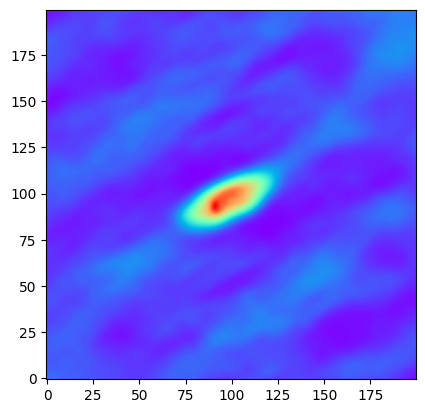

In [39]:
def add_images(file1, file2):
    data1 = fits.getdata(file1)
    data2 = fits.getdata(file2)
    data1 = data1.squeeze()
    data2 = data2.squeeze()
    data1 = crop_image(data1,100)
    data2 = crop_image(data2,100)
    new_data = (data1 + data2)
    return new_data


fil1 = filenames[2]
fil2 = filenames[1]
bild = add_images(fil1,fil2)
plt.imshow(bild, origin='lower', cmap='rainbow')
plt.show()


